In [172]:
#import packages
import numpy as np
import pandas as pd
import math as mt
from itertools import starmap
import sys 
# Printing all values of array without truncation 
np.set_printoptions(threshold=sys.maxsize) 
import numpy_indexed as npi
import random
import time

from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

""" for multiprocess, paralel find inspiration here """ \
"""https://www.youtube.com/watch?v=IPMcV_IXtX4"""

#think about paralelising different parameter simulations


' for multiprocess, paralel find inspiration here https://www.youtube.com/watch?v=IPMcV_IXtX4'

In [173]:
def initialise(N,nt,beta0,beta1,alpha0,alpha1):
    lattice = np.zeros(nt,dtype=object)
    lattice[nt-N:] = 1
    random.shuffle(lattice)
    sq_nt=int(mt.sqrt(nt))
    lattice = lattice.reshape(sq_nt,sq_nt)
    positions=np.where(lattice==1)
    #print(lattice)
    
    cols=['ag_id','beta0','beta1','alpha0','alpha1',
          'rank_id','i','j','ij','n_offs','id_mother',
          'rank_mother','matril','gs','alive','juvenile']
    agents = np.zeros(N*len(cols),dtype='int')
    agents = agents.reshape(N,len(cols))
    agents = pd.DataFrame(agents,columns=cols)
    agents['ag_id']=list(range(N))
    agents['beta0']= beta0#solitbeta if beta is None else beta #should be all solitary to start or the parameters I set
    agents['beta1']= beta1 #solitbeta if beta is None else beta
    agents['alpha0']= alpha0
    agents['alpha1']= alpha1
    agents['rank_id']=1
    agents['i']=positions[0]
    agents['j']=positions[1]
    agents['ij']=agents['i'].astype(str)+"-"+agents['j'].astype(str)
    agents['n_offs']=0
    agents['id_mother']=None
    agents['rank_mother']=None
    agents['matril']=list(range(N))
    agents['gs']=1
    agents['alive']=1
    agents['juvenile']=0
    agents['floater']=0
    agents['generation']=0
    agents = agents.astype(dtype= {'ag_id':"Int64",
                                   'beta0':"float64",'beta1':"float64",'alpha0':"float64",'alpha1':"float64",
                                   'rank_id':"Int64",'i':"Int64",'j':"Int64",'ij':'str',
                                   'n_offs':"Int64",'id_mother':"Int64",'rank_mother':"Int64",
                                   'matril':"Int64",'gs':"Int64",'alive':"Int64",'juvenile':"Int64",
                                   'floater':"Int64",'generation':"Int64"})
    #print(agents)
    
    
    #lattice is to keep the spatial information with low memory, terr will only contain the territories with agents
    # BREEDING TERRITORIES' matrix. The bter correspond to the positions asigned in lattice[x,y]==1. 
    
    cols=['terr_id','i','j','ij','gs','ranklist']
    terr = np.zeros(N*len(cols),dtype='int')
    terr = terr.reshape(N,len(cols))
    terr = pd.DataFrame(terr,columns=cols)
    terr['terr_id']=list(range(N))
    terr['i']=positions[0]
    terr['j']=positions[1]
    terr['ij']=terr['i'].astype(str)+"-"+terr['j'].astype(str) #if all territories where in([1 if x==True else 0 for x in terr['ij'].isin(agents['ij'])])
    terr['gs']=1
    rnkl=[]
    [rnkl.append([1]) for i in range(N)]
    #print(rnkl)
    terr['ranklist']=rnkl
    terr = terr.astype(dtype= {'terr_id':"Int64",'i':"Int64",'j':"Int64",'ij':'str','gs':"Int64"})
    #print(terr)
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("INITIALISE",agents,terr,"repetition ij",boolean,sep="\n")
    
    return agents, terr, lattice, #floaterlist#, TotoffRank, AbsoffRank, ReloffRank, total, Alive


def actualise(agents,terr,lattice):
    #separate into dead ids and floaters and residents 
    #np.split(agents, np.where(agents.alive == 0 | agents.floater==1)[0] + 1)
    #agents.loc[:,"floater"]=0
    deadfloat=np.where((agents.alive == 0) | (agents.floater==1))[0]
    if(len(deadfloat)>0):
        nores=agents.loc[deadfloat,]
        agents=agents.loc[np.where((agents.alive == 1) & (agents.floater==0))[0],]
        
    if(len(agents)>0):#if still any agent resident alive
        #group size: 
        #count ids per territory and add the count in the terr and agents df
        gs_terr=agents.groupby('ij')['ag_id'].count()
        agents.loc[:,'gs'] = agents.ij.map(gs_terr).values
        agents.loc[:,'gs'] = agents['gs'].fillna (0)
        terr.loc[:,'gs'] = terr.ij.map(gs_terr).values
        terr.loc[:,'gs'] = terr['gs'].fillna (0)
        intvector = np.vectorize(int)
        #terr.loc[:,"gs"]=intvector(terr["gs"].values)
        #print(agents,terr,sep="\n")

        #actualise ranks
        def sortgroups(data,var):
            x=data.sort_values(var)
            x[var]=range(1,len(x)+1)
            return(x) 
        #print("agents",agents)
        agents=agents.groupby('ij').apply(lambda x: sortgroups(x,'rank_id')).reset_index(drop=True)
        #print("agents",agents)
        terr_rank=agents.groupby('ij')['rank_id'].apply(list)
        terr.loc[:,'ranklist'] = terr.ij.map(terr_rank)
        isna = terr['ranklist'].isna()
        terr.loc[isna, 'ranklist'] = pd.Series([[]] * isna.sum()).values
        #restore agents in id order
        agents=agents.sort_values(["ag_id"],ascending=True).reset_index(drop=True)
        #terrij=terr.loc[:,"ij"].split("-")
        ijij = terr.ij.str.split("-",expand=True,)

        #print(ijij)
        #actualise lattice    
        lattice[intvector(ijij.loc[:,0]),intvector(ijij.loc[:,1])]=terr["gs"]

        if(len(deadfloat)>0):
            agents=agents.append(nores).sort_values(["ag_id"],ascending=True).reset_index(drop=True)
        #print(agents)
        
    else:#if no residents still alive set all to 0
        #print(agents)
        agents=nores.copy()
        #print(agents)
        #print(terr)
        terr.loc[:,'gs'] =0
        rnkl=[]
        [rnkl.append([0]) for i in range(len(terr))]
        #print(rnkl)
        terr['ranklist']=rnkl
        #print(terr)
        lattice[:]=0
        #print(agents,terr,lattice,sep="/n")
        
        
    
    #print(agents,terr,lattice,sep="\n")
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("ACTUALISE",agents,terr,"repetition ij",boolean,sep="\n")

    return agents, terr, lattice

def dispersal(agents,terr):
    juvidx=np.where((agents.alive==1)&(agents.juvenile==1))
    if(len(juvidx[0])>0):
        #print("ENTRY",agents,sep='\n')
        juv=agents.loc[juvidx]
        adultdom=agents.loc[np.where((agents.alive==1)&(agents.juvenile==0) & (agents.rank_id==1) & (agents.floater==0))]
        #print("JUVENILES",juv,"DOMINANTS",adultdom,sep='\n')
        addomidx=adultdom.reset_index().set_index('ij').loc[juv.ij, 'index'].values
        #print("DOMINANTS IDX",addomidx,sep='\n')
        #print("lens",len(juv),len(adultdom),len(addomidx))
        GS=agents.loc[addomidx]["gs"].values.astype("Int64")
        b0=agents.loc[juvidx]["beta0"].values
        b1=agents.loc[juvidx]["beta1"].values
        a0=agents.loc[addomidx]["alpha0"].values
        a1=agents.loc[addomidx]["alpha1"].values
        #print("b0",b0,"b1",b1,"a0",a0,"a1",a1,"GS",GS,sep="\n")
        #print("b0",b0.dtype,"b1",b1.dtype,"a0",a0.dtype,"a1",a1.dtype,"GS",GS.dtype,sep="\n")
        pdecide=1/(1+np.exp(b0+b1*GS)) #prob offspring decides to stay
        paccept=1/(1+np.exp(a0+a1*GS)) #prob highest ranking female accepts
        pjoin=pdecide*paccept
        #pjoin[1]=1
        #print(pdecide,paccept,pjoin,sep="\n")
        pn=np.random.rand(len(pjoin))
        pjoinmin=pjoin-pn
        stay=np.where(pjoinmin>=0)
        go=np.where(pjoinmin<0)    

        #set ids in their territory 
        if len(stay)>0:
            juvstayidx=juvidx[0][stay]
            addomstayidx=addomidx[stay]
            #set rank to last in all juveniles staying in smae terr to be actualised in actualise()
            terrjuvidx=terr.reset_index().set_index('ij').loc[agents.ij[juvstayidx], 'index'].values
            agents.loc[juvstayidx,"rank_id"]=terr.ranklist[terrjuvidx].map(max).values

        #set as floaters those that didn't stay
        if len(go)>0:
            juvgoidx=juvidx[0][go]
            addomgoidx=addomidx[go]
            agents.loc[juvgoidx,"ij"]=None #set as floaters
            agents.loc[juvgoidx,"floater"]=1
            agents.loc[juvgoidx,"gs"]=None

        agents.loc[:,"juvenile"]=0
        if(prntlast==True):
            boolean = not terr["ij"].is_unique
            print("DISPERSAL",agents,terr,"repetition ij",boolean,sep="\n")
    return(agents)

def survival(agents,terr,Sflo,Sb,y,Smax):
    resid=np.where((agents.alive == 1) & (agents.floater==0))[0]
    Sbv=np.repeat(Sb,len(resid))
    yv=np.repeat(y,len(resid))
    Smaxv=np.repeat(Smax,len(resid))
    GS=agents.loc[resid,"gs"].values.astype("Int64")
    #print("resid",resid,sep="\n")
    #print("gs==2",np.where((agents["gs"]==2)),sep="\n")
    #print("gs",agents.loc[resid,],sep="\n")
    #print("GS",GS,sep="\n")
    respsur=Sbv+(Smaxv-Sbv)*(1-np.exp(-yv*GS))
    
    #print("respsur",respsur,sep="\n")
    n1=np.random.rand(len(respsur))
    #print("n1",n1,sep="\n")
    resmin=respsur-n1
    #print("resmin",resmin,sep="\n")
    idxresdead=resid[np.where(resmin<0)]
    #print(agents)
    #print(resid,len(resid),len(respsur),sep="\n")
    
    floater=np.where((agents.alive == 1) & (agents.floater==1))[0]    
    flopsur=np.repeat(Sflo,len(floater))#1-prob dy
    n2=np.random.rand(len(flopsur))
    flmin=flopsur-n2
    idxflodead=floater[np.where(flmin<0)]
    #print(floater,len(floater),len(flopsur),sep="\n")
    #print(agents)
    agents.loc[idxresdead,"alive"]=0
    agents.loc[idxflodead,"alive"]=0
    
    #print(respsur,n1,resmin,idxresdead,flopsur,n2,flmin,idxflodead,sep="\n")
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("SURVIVAL",agents,terr,"repetition ij",boolean,sep="\n")
    return agents


def colonise(agents,terr,lattice):
    floater=np.where((agents.alive == 1) & (agents.floater==1))[0] #find floaters
    positions=np.where(lattice==0) #find empty territories
    #print("floater",floater)
    #print("len",len(floater))
    #print("positions",positions)
    #print("lenpositions",len(positions[0]))
    #print("floater",floater)
    #print("lenflo",len(floater))
    #if there are any territories available and floaters searching
    if(len(positions[0])>0 and len(floater)>0): 
        if(len(positions[0])<len(floater)):#if there are more floaters than empty territories choose some
            colon=np.random.choice(floater, len(positions[0]), replace=False)
        else: colon=floater.copy()
        
        #choose randomly the indices from territories
        idxnewterr=np.random.choice(range(len(positions[0])),len(colon), replace=False)
        #print("colon",colon,sep="\n")
        #print("idxnewterr",idxnewterr,sep="\n")
        #print("agentscolon before",agents.loc[colon,],sep="\n")
        agents.loc[colon,'rank_id']=1
        agents.loc[colon,'i']=positions[0][idxnewterr].astype('int')
        agents.loc[colon,'j']=positions[1][idxnewterr].astype('int')
        #display(agents)
        #print("colons",colon,sep="\n")
        #function from @jan-glx in stackoverflow. Allows to correct for problems arising when only one colon is attempting to settle
        def paste(*args, sep = " ", collapse = None):
            import itertools
            l = [list(arg) if isinstance(arg, str) else arg if hasattr(arg, '__len__') else list(str(arg)) for arg in args]
            l = list(itertools.islice((sep.join(parts) for parts in zip(*(itertools.cycle(map(str, e)) for e in l))), (max((len(x) for x in l)))))
            if collapse is not None:
                l = collapse.join(l)
            return l
        agents.loc[colon,'ij']=paste(agents.loc[colon,'i'].astype('int').astype('str'),agents.loc[colon,'j'].astype('int').astype('str'),sep="-")#(agents.loc[colon,'i'].astype('int').astype('str')+"-"+agents.loc[colon,'j'].astype('int').astype('str')).values
        agents.loc[colon,'gs']=1
        agents.loc[colon,'floater']=0
        #print("agentscolon AFTER",agents.loc[colon,],sep="\n")


        #create new territories
        cols=['terr_id','i','j','ij','gs','ranklist']
        tr_id=range(max(terr.terr_id),max(terr.terr_id)+len(colon))
        iji=agents.loc[colon,'i'].values.astype('int')
        ijj=agents.loc[colon,'j'].values.astype('int')
        ijij=agents.loc[colon,'ij']
        gs=agents.loc[colon,'gs']
        rnkl=[]
        [rnkl.append([1]) for i in range(len(colon))]

        new_terr= pd.DataFrame([tr_id,iji,ijj,ijij,gs,rnkl])
        new_terr = new_terr.transpose()
        new_terr.columns = ['terr_id','i','j','ij','gs','ranklist']
        #print("new",new_terr,sep="\n")
        #print("bef",terr,sep="\n")
        terr=terr.append(new_terr).reset_index(drop=True)
        terr=terr.loc[np.where(terr.gs>0)[0],:].reset_index(drop=True)
        terr = terr.astype(dtype= {'terr_id':"Int64",'i':"Int64",'j':"Int64",'ij':'str','gs':"Int64"})
    
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("COLONISE",agents,terr,"repetition ij",boolean,sep="\n")
    return agents, terr


def reproduce(agents,terr,F0,a,s,mu,sigma,t):
    #print("ENTRY",agents,sep="\n")
    #If you are resident female, alive, and you were not born this year:
    #display(agents)
    idx=np.where((agents['floater']==0) & (agents['alive']==1))
    #apply prob reprod
    GS=agents.loc[idx]["gs"].values.astype("Int64")             #Set group size
    R=agents.loc[idx]['rank_id'].values                         #Set Rank
    #print(GS,R,sep="\n")
    prep=(F0*(1-(a*GS))*R**(-s))/2  
    #Apply reprod function divide by two to account for the fact that half offspring is male(not modeled)
    #print(pd.concat([pd.DataFrame(R),pd.DataFrame(prep)],axis=1))
    
    pn=np.random.rand(len(prep))
    prepmin=prep-pn
    #print("prepmin",prepmin,sep="\n")
    idxrep=idx[0][np.where(prepmin>=0)]
    agents.loc[idxrep,"n_offs"]=agents.loc[idxrep]["n_offs"].values+1
    #print("agents_n_offs",agents,sep="\n")
    
    #create columns, then put them together and append to df
    ag_id=list(range(agents.ag_id.max()+1,agents.ag_id.max()+1+len(idxrep)))
    
    b0=agents.loc[idxrep,"beta0"]+np.random.normal(mu, sigma, len(idxrep))
    b1=agents.loc[idxrep,"beta1"]+np.random.normal(mu, sigma, len(idxrep))
    a0=agents.loc[idxrep,"alpha0"]+np.random.normal(mu, sigma, len(idxrep))
    a1=agents.loc[idxrep,"alpha1"]+np.random.normal(mu, sigma, len(idxrep))

    iji=agents.loc[idxrep,"i"].values
    ijj=agents.loc[idxrep,"j"].values
    ijij=agents.loc[idxrep,"ij"].values
    #print("lenag_id",len(ag_id))
    #print("lenb0",len(b0))
    #print("leniji",len(iji))
    #print("lenijj",len(ijj))
    #print("lenijij",len(ijij))
    #print("ij etc",iji,ijj,ijij,sep="\n")
    
    
    n_offs=np.repeat(0,len(idxrep))
    id_mother=agents.loc[idxrep,"ag_id"]
    #print("ijij",ijij,sep="\n")
    ijij_terr=terr.reset_index().set_index('ij').loc[ijij, 'index'].values
    #print("ijij_terr",ijij_terr,sep="\n")
    #print("terr",terr,sep="\n")
    #print("ranlist_ijij_terr",terr.loc[ijij_terr,"ranklist"].map(max).values+1,sep="\n")

    rank_id=terr.loc[ijij_terr,"ranklist"].map(max).values+1    
    rank_mother=agents.loc[idxrep,'rank_id']
    matril=agents.loc[idxrep,"matril"]
    gs=agents.loc[idxrep,"gs"]
    alive=np.repeat(1,len(idxrep))
    juvenile=np.repeat(1,len(idxrep))
    floater=np.repeat(0,len(idxrep))
    gener=np.repeat(t+1,len(idxrep))#agents.loc[idxrep,"generation"]+1
    #[ag_id,b0,b1,a0,a1,rank_id,iji,ijj,ijij,n_offs,id_mother,rank_mother,matril,gs,alive,just_dead,juvenile].map(pd.DataFrame)
    new_ag= pd.DataFrame([ag_id,b0,b1,a0,a1,rank_id,n_offs,id_mother,rank_mother,matril,gs,alive,juvenile,floater,gener])
    #new_ag=new_ag.astype(float)
    new_ag = new_ag.transpose()
    new_ag.columns = ['ag_id','beta0','beta1','alpha0','alpha1','rank_id','n_offs','id_mother',
                      'rank_mother','matril','gs','alive','juvenile','floater','generation']
    #print(new_ag)
    new_ag=new_ag.assign(i=iji,j=ijj,ij=ijij)
    
    new_ag = new_ag.astype(dtype= {'ag_id':"Int64",
                                   'beta0':"float64",'beta1':"float64",'alpha0':"float64",'alpha1':"float64",
                                   'rank_id':"Int64",'i':"Int64",'j':"Int64",'ij':'str',
                                   'n_offs':"Int64",'id_mother':"Int64",'rank_mother':"Int64",
                                   'matril':"Int64",'gs':"Int64",'alive':"Int64",'juvenile':"Int64",
                                   'floater':"Int64",'generation':"Int64"
                                  })
    #print("new_ag",new_ag,sep="\n")
    
    agents=agents.append(new_ag,sort=True).reset_index(drop=True)
    if(prntlast==True):
        boolean = not terr["ij"].is_unique 
        print("REPRODUCE",agents,terr,"repetition ij",boolean,sep="\n")
    return agents

def run(T,N,nt,beta0,beta1,alpha0,alpha1,Sflo,Sb,y,Smax,F0,a,s,mu,sigma_min,sigma_max,nsigma):
    #mutation rates
    sigmas = np.linspace(sigma_min, sigma_max, num=nsigma, endpoint=True, retstep=False, dtype=float)
    #print(sigmas)
    #for each mutation rate run all generations
    for sigma_idx in range(len(sigmas)):
        #print(sigma_idx)
        #baseline survival probability lone breeder=0.8 with these param combs
        agents, terr, lattice=initialise(N,nt,beta0,beta1,alpha0,alpha1)
        for t in range(T):
            #print(t)
            #print(agents.groupby(["generation","alive","floater"]).size()\
            #      .reset_index(name='size') \
            #      .sort_values(['alive',"floater","generation"], ascending=True))
            #print(lattice)
            agents=dispersal(agents,terr)
            agents, terr, lattice=actualise(agents,terr,lattice)
            agents=survival(agents,terr,Sflo,Sb,y,Smax)
            agents, terr, lattice=actualise(agents,terr,lattice)
            agents, terr=colonise(agents,terr,lattice)
            agents, terr, lattice=actualise(agents,terr,lattice)
            agents=reproduce(agents,terr,F0,a,s,mu,sigmas[sigma_idx],t)
            agents, terr, lattice=actualise(agents,terr,lattice)
            nbalive=agents[agents["alive"] == 1].shape[0]
            #print(nbalive)
            if nbalive==0:#if all ids died break the inner loop
                agents['sigma']=sigmas[sigma_idx]
                if sigma_idx==0:#if first loop                    
                    agentsall=agents.copy()
                else:#add to big table results
                    agentsall=pd.concat([agentsall,agents])
                break
            if t==(T-1):#if last generation
                agents['sigma']=sigmas[sigma_idx]
                #print(agents)
                if sigma_idx==0:#if first loop                    
                    agentsall=agents.copy()
                else:#add to big table results
                    agentsall=pd.concat([agentsall,agents])
    return(agentsall)


In [ ]:
T=2000 #nb of generations
N=90 #number of individuals at t0
nt=10*10 #needs to have a perfect square root
#parameters
#REPRODUCTION
F0=2 #baseline nb offspring
a=0.2 #strength gsize effect on rep
s=0.5 #strength effect hierarchy on rep
#DISPERSAL (evolving params)
#same as initial values in Port et al. 2020 The evolution of social philopatry in female primates
beta0=5#-10 #intercept logit effect gs on decision offspring to stay or disperse (with current values all females disperse, "solitary species")
beta1=0  #strength effect gs on decision offspring to stay or disperse
alpha0=5 #intercept logit effect gs on decision dominant female to stay or disperse (with current values all females are rejected, "solitary species")
alpha1=0 #strength effect gs on decision dfemale to stay or disperse

#params to test possibility of groups to exist (ids tend not to disperse)
# beta0=0#-10 #intercept logit effect gs on decision offspring to stay or disperse (with current values all females disperse, "solitary species")
# beta1=0  #strength effect gs on decision offspring to stay or disperse
# alpha0=0 #intercept logit effect gs on decision dominant female to stay or disperse (with current values all females are rejected, "solitary species")
# alpha1=0 #strength effect gs on decision dfemale to stay or disperse


#MUTATION rates for evolving params
mu=0 # mean
sigma_min=1 #std deviations min
sigma_max=1000 # max
nsigma=4 # nb values in range min max

#SURVIVAL
#1st three params shape curve relating group size and survival (this config 0.8 for resid female rank1)
y=0.5  
Sb=0.5 
Smax=0.95 #maximum survival probability in pop
Sflo=0.6 #floater survival prob



prntlast=False
#print(agents,'\n',terr,'\n',lattice)
agentss=run(T,N,nt,beta0,beta1,alpha0,alpha1,Sflo,Sb,y,Smax,F0,a,s,mu,sigma_min,sigma_max,nsigma)


In [ ]:
agentss.describe()

In [ ]:
cols = ['generation','sigma','gs','alpha0','alpha1','beta0','beta1']
trial=agentss.loc[np.where((agentss['floater']==0)&(agentss['alive']==0))][cols]
trial=trial.apply(pd.to_numeric)

cols = ['gs','alpha0','alpha1','beta0','beta1']
trialgs=trial.groupby(['sigma','generation'], as_index=False)[cols].mean()
trialgs

In [ ]:
#create plots to observe evolution of dispersal parameters (hereditary dispersal rules) 
#based on the sigma of mutation
#as well as their efffect on mean group size per generation

#plotting code adapted from answer of Julien Marrec in
#https://stackoverflow.com/questions/41494942/pandas-dataframe-groupby-plot
grouped = trialgs.groupby('sigma', as_index=True)
ncols=1
nrows = int(np.ceil(grouped.ngroups/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax)
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(grouped.get_group(key).index, grouped.get_group(key)['gs'],color="blue",marker="o")
    ax2.set_ylabel("groupsize",color="blue",fontsize=14)
    

ax.legend()
plt.show()

In [ ]:
trialf=agentss.groupby(['sigma','generation','floater']).size().to_frame('popsize').reset_index()
trialgssize=trial.groupby(['sigma','generation'])['gs'].mean().to_frame('gs').reset_index()
triall=trialf.merge(trialgssize, on=['sigma','generation'], how='left')
#print(triall)

grouped = triall.groupby(['sigma'], as_index=True)
#print(grouped)
ncols=1
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12), sharey=False)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    #print(grouped.get_group(key))
    df=grouped.get_group(key)[['generation','floater','popsize','gs']]
    df.set_index('generation', inplace=True)
    #print(df)
    df.groupby('floater')['popsize'].plot(ax=ax)
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(df.index, df['gs'],color="blue",marker="o")
    ax2.set_ylabel("groupsize",color="blue",fontsize=14)
    

ax.legend()
plt.show()

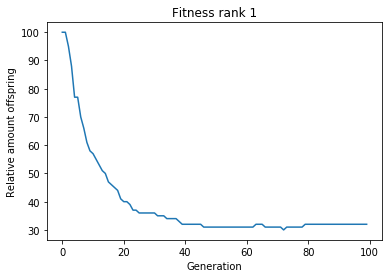

In [23]:
#coming soon fitness by rank and dispersal strategy
plt.plot(y)
plt.xlabel("Generation")
plt.ylabel("Relative amount offspring")
plt.title('Fitness rank 1')
plt.show()